# Sentinel-2 Processing for Precision Ag (PAGAF) Project
Madeline Jones

<b>Purpose:</b> Develop a geoprocessing workflow in Python for generating Nitrogen Sufficiency Index (SI) geotiffs from a set of 17 Sentinel-2 images collected over Adair County, IA throughout the 2017 corn season (03/2017 - 09/2017). These geotiffs will be used to inform farmers how much Nitrogen to give to their corn in [NLT's open source PAGAF web application](https://pagaf.nltmso.com/), depending on how far along they are in the growing season. 

The basis for this analysis was established by Holland and Schepers (see References below).

<b>References</b> \
Holland, K. H., and J. S. Schepers. "Derivation of a variable rate nitrogen application model for in‐season fertilization of corn." Agronomy Journal 102.5 (2010): 1415-1424. \
Holland, Kyle H., and James S. Schepers. "Use of a virtual-reference concept to interpret active crop canopy sensor data." Precision Agriculture 14.1 (2013): 71-85.



<img src="PAGAF.png" alt="Screen shot of PAGAF app." title="Screenshot of In-Season N Management Demo in PAGAF Web App" />

In [1]:
# import time library to determine total run time
import time
t = time.time()

In [2]:
# import libraries for reading imagery metadata
from bs4 import BeautifulSoup as bs
import lxml

In [3]:
# import open source Python libraries for geospatial analysis
import sys, os, struct
import osgeo.gdal as gdal
import rasterio
from rasterio import plot
import numpy as np
import glob

## Sentinel-2 Bands
Source: https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/

<img src="https://s3.amazonaws.com/content.satimagingcorp.com/media/cms_page_media/1530/image001.png" alt="Screen shot of PAGAF app." title="Screenshot of In-Season N Management Demo in PAGAF Web App"/>

In [4]:
# import single S2 image
# read in Red, Green, Blue, RedEdge1 and NIR bands as separate single-band rasters
IMG_DATA = 'S2/S2A_MSIL1C_20170609T171301_N0205_R112_T15TUF_20200713T143315.SAFE/GRANULE/L1C_T15TUF_A010262_20170609T172015/IMG_DATA/'
IMG_NAME = IMG_DATA.split("MSIL1C_")[1].split('.SAFE')[0]

# get filenames of each band
band2 = glob.glob(IMG_DATA+"/*B02.jp2")[0] #blue
band3 = glob.glob(IMG_DATA+"/*B03.jp2")[0] #green
band4 = glob.glob(IMG_DATA+"/*B04.jp2")[0] #red
band5 = glob.glob(IMG_DATA+"/*B05.jp2")[0] #rededge1
band8 = glob.glob(IMG_DATA+"/*B08.jp2")[0] #nir

# open band imgs w/ rasterio
band2_rio = rasterio.open(band2, driver='JP2OpenJPEG') #blue
band3_rio = rasterio.open(band3, driver='JP2OpenJPEG') #green
band4_rio = rasterio.open(band4, driver='JP2OpenJPEG') #red
band5_rio = rasterio.open(band5, driver='JP2OpenJPEG') #rededge1
band8_rio = rasterio.open(band8, driver='JP2OpenJPEG') #nir

# open True Color Image (TCI) for preview of scene
tci = glob.glob(IMG_DATA+"/*TCI.jp2")[0]
tci_rio = rasterio.open(tci, driver='JP2OpenJPEG') #tci

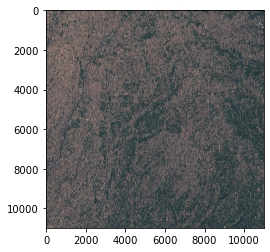

In [5]:
# preview True Color Image
from rasterio.plot import show
show(tci_rio.read())

In [6]:
# read in xml (metadata) file
ROOT_PATH = IMG_DATA.split('/GRANULE')[0]
xml = glob.glob(ROOT_PATH+"/MTD*.xml")[0]

with open(xml, "r") as file:
    content = file.readlines()
    content = "".join(content)
    bs_content = bs(content, "lxml")

In [7]:
# scan xml file for cloud coverage percentage
result = bs_content.find("cloud_coverage_assessment")
cloud_pct = float(result.text)
print('Cloud Coverage: {}%'.format(cloud_pct))

Cloud Coverage: 0.0%


In [8]:
# create 5-band stack (blue, green, red, red edge, nir)
output = r"S2/OUTPUT/{}_S2stack_5bands.tif".format(IMG_NAME)
os.system('gdal_merge.py -o ' + output + ' -separate -co PHOTOMETRIC=RGB ' + band2 + ' ' + band3 + ' ' + band4 + ' ' + band5 + ' ' + band8)

0

In [9]:
# define cloud mask file path and shp output file path
cloud_gml = IMG_DATA.split("/IMG")[0]+"/QI_DATA/MSK_CLOUDS_B00.gml"
cloud_shp = IMG_DATA.split("/IMG")[0]+"/QI_DATA/MSK_CLOUDS_B00.shp"

In [10]:
# convert gml cloud mask to shapefile
cmd = """ogr2ogr -f 'ESRI Shapefile' {} {} """.format(cloud_shp, cloud_gml)

os.system(cmd)     

0

In [11]:
# burn cloud mask into raster
cmd = """gdal_rasterize -b 1 -b 2 -b 3 -b 4 -b 4 -burn 0 -burn 0 -burn 0 -burn 0 -burn 0 -l MSK_CLOUDS_B00 {} {}""".format(cloud_shp, output)

os.system(cmd)   


256

## Geoprocessing Steps: Creating a Corn Mask
I created a corn mask using the [USDA 2017 National Cropland Data Layer](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php) and the Common Land Unit (CLU) data over Adair County, IA. 

"A Common Land Unit (CLU) is the smallest unit of land that has a permanent, contiguous boundary, a common land cover and land management, a common owner and a common producer in agricultural land associated with USDA farm programs." (Source: [USDA](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-products/common-land-unit-clu/index))

From the 2017 CDL raster, I exported all pixels categorized as Corn. I then used Zonal Statistics to determine which Common Land Units were growing primarily Corn.

This corn mask will be used to clip the S2 images so that the Nitrogen Sufficiency analysis is only performed over known areas growing corn.

<img src="CLU_majority_corn.png" alt="Adair County, Iowa Corn Mask."/>

In [12]:
# import corn mask shapefile
cornmask_shp = r"AdairIA/CLUs_MajorityCorn_AdairIA.shp"

import fiona
#shape = fiona.open(cornmask_shp)
with fiona.open(cornmask_shp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [13]:
# using corn mask on 5band stack geotiff
from rasterio.mask import mask
with rasterio.open(output) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, all_touched=False, invert=False, nodata=0, crop = True, pad = True)
    out_meta = src.meta

In [14]:
# grabbing metadata from 5band stack so when i export the corn masked image it contains the same metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [15]:
# export corn-masked 5band stack to geotiff
output_cornmask = r"S2/OUTPUT/{}_S2stack_5bands_cornmask.tif".format(IMG_NAME)

with rasterio.open(output_cornmask, "w", **out_meta) as dest:
    dest.write(out_image)

In [16]:
# get metadata of mosaic for sanity check
stack_rio = rasterio.open(output_cornmask)
stack_rio.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 3891,
 'height': 3902,
 'count': 5,
 'crs': CRS.from_epsg(32615),
 'transform': Affine(10.0, 0.0, 357410.0,
        0.0, -10.0, 4596060.0)}

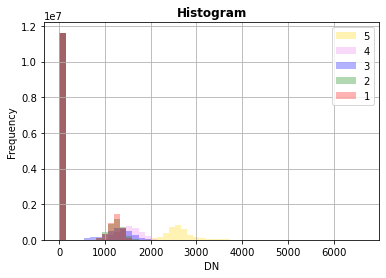

In [17]:
# histogram of 5 bands in corn-masked 5band stack (masked pixels are 0's)
from rasterio.plot import show_hist
show_hist(stack_rio, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

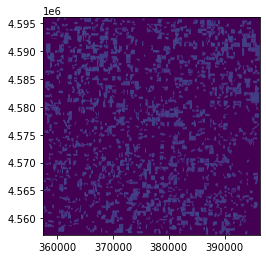

In [18]:
# plot the corn-masked stack (masked pixels are 0's)
plot.show(stack_rio)

In [19]:
# read in red edge and nir bands as numpy arrays
rededge = stack_rio.read(4).astype('float64') #rededge1
nir = stack_rio.read(5).astype('float64') #nir

# set 0's to nan for math coming up
rededge[rededge==0] = np.nan
nir[nir==0] = np.nan

The Nitrogen Sufficiency Index (NSI) is based on the Chlorophyll Index (CI). First, the Chlorophyll Index is calculated from the S2 image, and then the Nitrogen Sufficiency Index is calculated by taking the top 40th-90th percentile of CI pixel values. This is due to the economic dropoff of pixels below the 40th percentile of CI values. The concept is that these pixels (corn) will not be able to make enough of a comeback in the growing season to overcome the cost of the amount of Nitrogen it would take to enhance corn growth.

[Chlorophyll Index Equation](https://www.indexdatabase.de/db/si-single.php?sensor_id=96&rsindex_id=131)

In [20]:
# calculate chlorophyll index (CI): NIR/Red Edge - 1
CI = np.where((nir+rededge)==0.0,0,((nir/rededge) - 1))

In [21]:
#export CI geotiff
CI_img = rasterio.open(r"S2/OUTPUT/{}_CI.tif".format(IMG_NAME), 'w', driver='Gtiff',
                      width = stack_rio.width,
                      height = stack_rio.height,
                      count = 1, crs = stack_rio.crs,
                      transform = stack_rio.transform,
                      dtype='float64')
CI_img.write(CI,1)
CI_img.close()

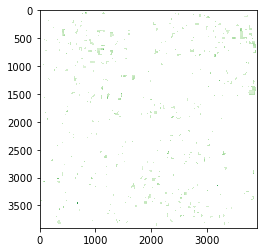

In [22]:
# plot CI
plot.show(CI, cmap = 'Greens')

In [23]:
# print min and max CI pixel values
minCI = CI[~np.isnan(CI)].min()
maxCI = CI[~np.isnan(CI)].max()
print("min CI: ", minCI)
print("max CI: ", maxCI)

min CI:  -0.4764267990074442
max CI:  4.368527918781726


In [24]:
# open CI image in rasterio
CI_img = rasterio.open(r"S2/OUTPUT/{}_CI.tif".format(IMG_NAME))

/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


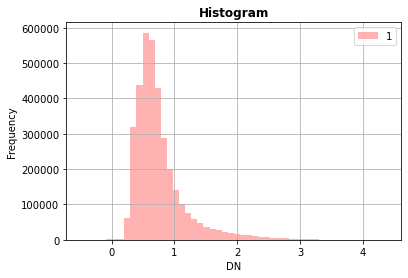

In [25]:
# view histogram of CI image
show_hist(CI_img, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [26]:
CIband = CI_img.read(1).astype('float64') #CI

In [27]:
# sanity check, print min/max vals again
print('min: ', CIband[~np.isnan(CIband)].min())
print('max: ', CIband[~np.isnan(CIband)].max())

min:  -0.4764267990074442
max:  4.368527918781726


In [28]:
# this function normalizes numpy arrays to range from 0 - 1 between the true min and max values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array[~np.isnan(array)].min(), array[~np.isnan(array)].max()
    return ((array - array_min)/(array_max - array_min))

In [29]:
# normalize CI
CIband_normalized = normalize(CIband)

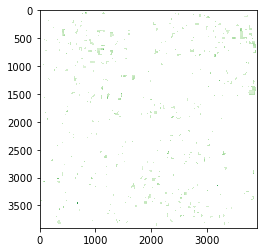

In [30]:
# plot normalized CI (should look the same as non-normalized CI!)
plot.show(CIband_normalized, cmap = 'Greens')

In [31]:
#export normalized CI (NCI) image as geotiff
NCI_img = rasterio.open(r"S2/NCI/{}_NCI.tif".format(IMG_NAME), 'w', driver='Gtiff',
                      width = CI_img.width,
                      height = CI_img.height,
                      count = 1, crs = CI_img.crs,
                      transform = CI_img.transform,
                      dtype='float64')
NCI_img.write(CIband_normalized,1)
NCI_img.close()

In [32]:
# open NCI image in rasterio
NCI_rio = rasterio.open(r"S2/NCI/{}_NCI.tif".format(IMG_NAME))

/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


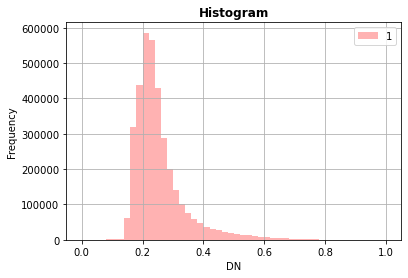

In [33]:
# view histogram of NCI image (should be same as CI histogram but range from 0 - 1)
show_hist(NCI_rio, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [34]:
NCIband = NCI_rio.read(1).astype('float64') #NCI

In [35]:
# sanity check, print min/max vals of NCI (should be 0 and 1)
print('min: ', NCIband[~np.isnan(NCIband)].min())
print('max: ', NCIband[~np.isnan(NCIband)].max())

min:  0.0
max:  1.0


In [36]:
# bottom limit of Sufficiency Index - 40th percentile
bottomlim = np.percentile(NCIband[~np.isnan(NCIband)], 40)
print(bottomlim)

0.22039930415636066


In [37]:
# top limit of Sufficiency Index - 90th percentile
toplim = np.percentile(NCIband[~np.isnan(NCIband)], 90)
print(toplim)

0.35678226470854174


In [38]:
# create Sufficiency Index (SI) array
SI_ = np.where(NCIband < bottomlim, np.nan, NCIband) # make all values less than 40th percentile nan
SI = np.where(NCIband > toplim, 1, SI_) # make all values greater than 90th percentile 1

<ipython-input-38-c3c44f41f099>:2: RuntimeWarning: invalid value encountered in less
  SI_ = np.where(NCIband < bottomlim, np.nan, NCIband) # make all values less than 40th percentile nan
<ipython-input-38-c3c44f41f099>:3: RuntimeWarning: invalid value encountered in greater
  SI = np.where(NCIband > toplim, 1, SI_) # make all values greater than 90th percentile 1


In [39]:
print('min: ', SI[~np.isnan(SI)].min())
print('max: ', SI[~np.isnan(SI)].max())

min:  0.22039930415636066
max:  1.0


In [40]:
#export SI array to geotiff
SI_img = rasterio.open(r"S2/OUTPUT/{}_SI.tif".format(IMG_NAME), 'w', driver='Gtiff',
                      width = CI_img.width,
                      height = CI_img.height,
                      count = 1, crs = CI_img.crs,
                      transform = CI_img.transform,
                      dtype='float64')
SI_img.write(SI,1)
SI_img.close()

In [41]:
# open SI image in rasterio
SI_rio = rasterio.open(r"S2/OUTPUT/{}_SI.tif".format(IMG_NAME))

/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


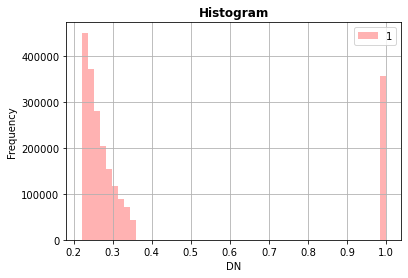

In [42]:
# view histogram of SI image 
show_hist(SI_rio, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [43]:
SI = SI_rio.read(1).astype('float64') #SI

In [44]:
# normalize SI array
NSI = normalize(SI)

In [45]:
# sanity check - print min/max of NSI (should be 0 and 1)
print('min: ', NSI[~np.isnan(NSI)].min())
print('max: ', NSI[~np.isnan(NSI)].max())

min:  0.0
max:  1.0


/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Madeline/opt/miniconda3/envs/data-science/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


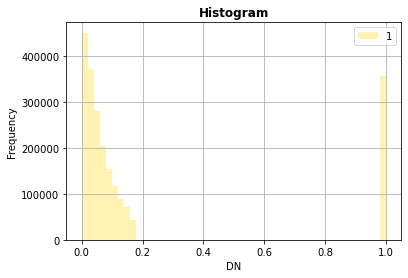

In [46]:
# view histogram of NSI (should be same as SI histogram but range from 0 - 1)
show_hist(NSI, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [47]:
#export normalized SI to geotiff
NSI_img = rasterio.open(r"S2/SI/{}_SI.tif".format(IMG_NAME), 'w', driver='Gtiff',
                      width = CI_img.width,
                      height = CI_img.height,
                      count = 1, crs = CI_img.crs,
                      transform = CI_img.transform,
                      dtype='float64')
NSI_img.write(NSI,1)
NSI_img.close()

In [48]:
# print total run time in seconds
elapsed = time.time() - t
print(elapsed)

146.12367796897888


In [49]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'time',
 'lxml',
 'sys',
 'os',
 'struct',
 'osgeo.gdal',
 'rasterio',
 'rasterio.plot',
 'numpy',
 'glob',
 'fiona',
 'types']